<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/Fourier/Fourier_series_%2B_Sarimax_for_differenced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [4]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

In [5]:
df_copy = df
df_copy['ANTAL_01'] = df_copy['ANTAL_01'].astype(float) - df_copy['ANTAL_01'].astype(float).shift(1)
df_copy = df_copy.dropna()

In [6]:
#training and test
training = df_copy.iloc[:-16,:]
print(training.index)
testing = df_copy.iloc[-16:, :]
training.head()

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1801, freq=None)


,ANTAL_01
DT,
2016-01-04,-58.0
2016-01-05,82.0
2016-01-06,-113.0
2016-01-07,-41.0
2016-01-08,-35.0


In [7]:
# Define number of Fourier terms to use
n_terms = 22

# Define the time period of the data (in this example, one year)
period = 365

In [8]:
# Create Fourier series terms
t = np.arange(len(training))
fourier_terms = []
for i in range(1, n_terms+1):
    fourier_terms += [np.sin(2*np.pi*i*t/period), np.cos(2*np.pi*i*t/period)]

In [9]:
# Add Fourier series terms to data frame
fourier_df = pd.DataFrame(np.array(fourier_terms).T, index=training.index, columns=[f'fourier_{i+1}' for i in range(2*n_terms)])
training = pd.concat([training, fourier_df], axis=1)

In [10]:
# Specify exogenous variables for SARIMAX model
exog_vars = ['fourier_{}'.format(i+1) for i in range(n_terms)]

In [11]:
# Train SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(training['ANTAL_01'], exog=training[exog_vars], order=(3,0,3), seasonal_order=(3,0,3,22))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
exogTest = training.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2[exog_vars])
exogvar = np.asarray(exogTest2[exog_vars])
exogvar
test_exog = pd.DataFrame(exogvar, index=testing.index)
test_exog

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
DT,,,,,,,,,,,,,,,,,,,,,
2022-11-30,-0.711657,0.702527,-0.999917,-0.012910,-0.693281,-0.720667,0.025818,-0.999667,0.729558,-0.683919,...,0.674444,0.738326,-0.051620,0.998667,-0.746972,0.664855,-0.997917,-0.064508,-0.655156,-0.755493
2022-12-01,-0.699458,0.714673,-0.999769,0.021516,-0.729558,-0.683919,-0.043022,-0.999074,0.668064,-0.744104,...,0.758306,0.651899,0.085965,0.996298,-0.635432,0.772157,-0.994218,0.107381,-0.785650,-0.618671
2022-12-02,-0.687053,0.726608,-0.998435,0.055917,-0.763889,-0.645348,-0.111659,-0.993747,0.601624,-0.798779,...,0.831171,0.556017,0.221922,0.975065,-0.508671,0.860961,-0.961130,0.276097,-0.888057,-0.459733
2022-12-05,-0.674444,0.738326,-0.995919,0.090252,-0.796183,-0.605056,-0.179767,-0.983709,0.530730,-0.847541,...,0.891981,0.452072,0.353676,0.935368,-0.369725,0.929141,-0.899631,0.436651,-0.958718,-0.284359
2022-12-06,-0.661635,0.749826,-0.992222,0.124479,-0.826354,-0.563151,-0.247022,-0.969010,0.455907,-0.890028,...,0.939856,0.341571,0.478734,0.877960,-0.221922,0.975065,-0.811539,0.584298,-0.995105,-0.098820
2022-12-07,-0.648630,0.761104,-0.987349,0.158559,-0.854322,-0.519744,-0.313107,-0.949718,0.377708,-0.925925,...,0.974100,0.226116,0.594727,0.803928,-0.068802,0.997630,-0.699458,0.714673,-0.995919,0.090252
2022-12-08,-0.635432,0.772157,-0.981306,0.192452,-0.880012,-0.474951,-0.377708,-0.925925,0.296713,-0.954967,...,0.994218,0.107381,0.699458,0.714673,0.085965,0.996298,-0.566702,0.823923,-0.961130,0.276097
2022-12-09,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892,-0.440519,-0.897743,0.213521,-0.976938,...,0.999917,-0.012910,0.790946,0.611886,0.238673,0.971100,-0.417194,0.908818,-0.891981,0.452072
2022-12-12,-0.608477,0.793572,-0.965740,0.259512,-0.924291,-0.381689,-0.501242,-0.865307,0.128748,-0.991677,...,0.991114,-0.133015,0.867456,0.497513,0.385663,0.922640,-0.255353,0.966848,-0.790946,0.611886


In [13]:
# predict using SARIMAX model
pred = results.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
pred, testing['ANTAL_01']

(1801    222.541571
 1802    176.216659
 1803      5.268606
 1804   -201.817672
 1805   -319.480562
 1806    -62.189448
 1807    -44.243325
 1808    -75.177899
 1809     -9.739987
 1810    -46.079321
 1811    -88.467209
 1812    -18.154706
 1813    -42.735141
 1814    -20.071923
 1815    -28.926016
 1816    -42.577397
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30    1301.0
 2022-12-01     317.0
 2022-12-02    -106.0
 2022-12-05   -1516.0
 2022-12-06    -159.0
 2022-12-07    -153.0
 2022-12-08    -135.0
 2022-12-09     -11.0
 2022-12-12    -105.0
 2022-12-13     -62.0
 2022-12-14     -98.0
 2022-12-15     101.0
 2022-12-16     -67.0
 2022-12-19     -61.0
 2022-12-20     -31.0
 2022-12-21     -31.0
 Name: ANTAL_01, dtype: float64)

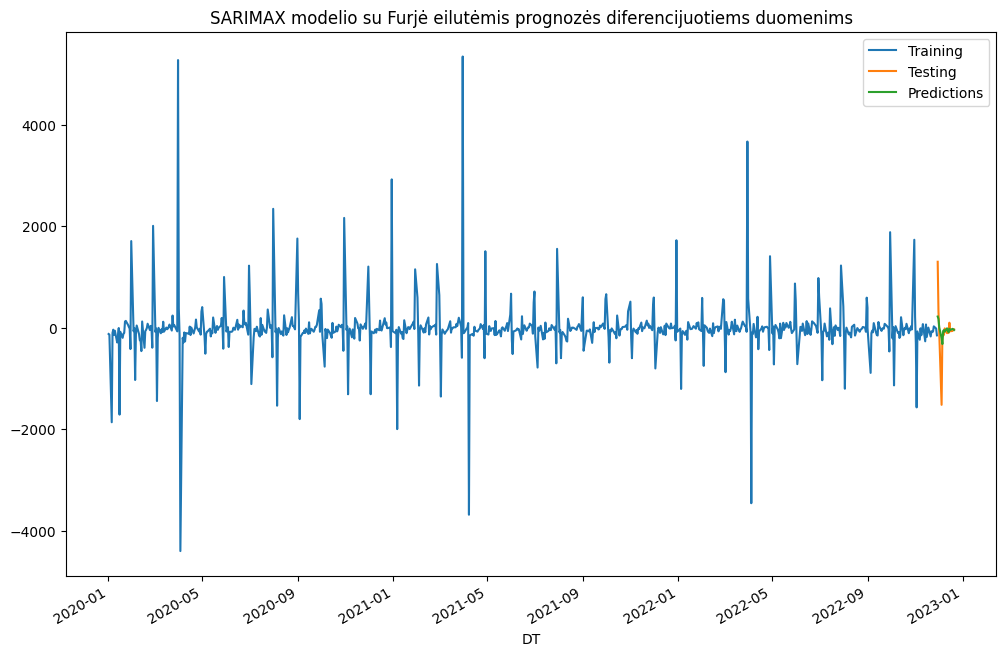

In [15]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su Furjė eilutėmis prognozės diferencijuotiems duomenims')
plt.legend()

In [ ]:
predictions = pred
last_values = df.iloc[:-16,:]
last_value = last_values[-1:]
last_value
original_preds= []
for pred in predictions:
    pred_value = last_value + pred
    original_preds.append(pred_value)
    last_value = pred_value
print(original_preds)

[                ANTAL_01
DT                      
2022-11-29  31128.541571,                 ANTAL_01
DT                      
2022-11-29  31304.758229,                 ANTAL_01
DT                      
2022-11-29  31310.026836,                 ANTAL_01
DT                      
2022-11-29  31108.209163,                 ANTAL_01
DT                      
2022-11-29  30788.728602,                 ANTAL_01
DT                      
2022-11-29  30726.539154,                 ANTAL_01
DT                      
2022-11-29  30682.295829,                ANTAL_01
DT                     
2022-11-29  30607.11793,                 ANTAL_01
DT                      
2022-11-29  30597.377942,                 ANTAL_01
DT                      
2022-11-29  30551.298621,                 ANTAL_01
DT                      
2022-11-29  30462.831413,                 ANTAL_01
DT                      
2022-11-29  30444.676707,                 ANTAL_01
DT                      
2022-11-29  30401.941566,               